In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.util import load_pickle_file
from utils.future3d_reconstruction_dataset import Future3D_Reconstruction_Dataset

In [9]:
data_root = 'data/Future-3D-Reconstruction'
image_size = 256
batch_size = 1

In [10]:
train_set = Future3D_Reconstruction_Dataset(data_root=os.path.join(data_root, 'train'), image_size=image_size)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(train_loader):
    img = data['image']
    mask = data['mask']
    verts = data['vertices']
    normals = data['normals']
    trans = data['translation']
    rot = data['rotation']
    K = data['K']
    for key in data:
        if type(data[key]) is list:
            print(key, data[key])
        else:
            print(key, data[key].size())
    if i >=0:
        break

image torch.Size([1, 3, 388, 388])
mask torch.Size([1, 1, 388, 388])
vertices torch.Size([1, 11930, 3])
normals torch.Size([1, 11930, 3])
translation torch.Size([1, 3])
rotation torch.Size([1, 3, 3])
K torch.Size([1, 3, 3])


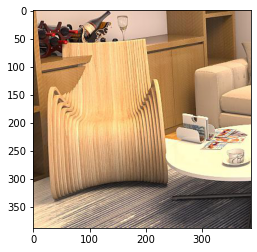

In [12]:
img_vis = (img.cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_vis)

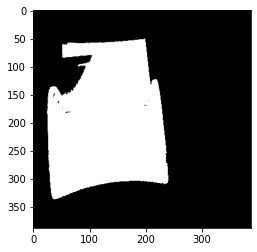

In [13]:
mask_vis = (mask.cpu().numpy()[0][0] * 255).astype(np.uint8)
plt.imshow(mask_vis, cmap='gray')

In [7]:
from utils.commom import project_to_camera, transform_points

In [14]:
from mathutils import Matrix
def get_camera_world(trans_vec, rot_mat):
    trans_4x4 = Matrix.Translation(trans_vec)
    rot_4x4 = Matrix(rot_mat).to_4x4()
    scale_4x4 = Matrix(np.eye(4))
    P = trans_4x4 @ rot_4x4 @ scale_4x4
    return np.array(P)

In [30]:
P = get_camera_world(trans.numpy()[0], rot.numpy()[0])
Rt = torch.from_numpy(P[:3, :][None]).float()
print(Rt.shape)

torch.Size([1, 3, 4])


In [16]:
def transform_points_(mesh_vertices, P):
    from scipy.spatial.transform import Rotation as R_
    rot_mat = P[:3, :3]
    trans_vec = P[:3, 3]
    r_blender = R_.from_matrix(rot_mat)
    x_angle, z_angle, y_angle = r_blender.as_euler('xyz', degrees=True) # xyz ->xzy blender_coordinate -> object coordinate
    r_object = R_.from_euler('yxz', [[-y_angle, 90 - x_angle, z_angle]], degrees=True)
    rot_mat_object = r_object.as_matrix()[0]
    dist = np.sqrt(np.square(trans_vec[0]) + np.square(trans_vec[1]) + np.square(trans_vec[2]))
    trans_vec_object = [0, 0, dist]
    mesh_vertices_trans = np.transpose(np.dot(rot_mat_object, np.transpose(mesh_vertices)))
    mesh_vertices_trans = mesh_vertices_trans - trans_vec_object
    return mesh_vertices_trans

In [17]:
print(verts.min(), verts.max())

tensor(-0.4838) tensor(0.9587)


In [18]:
verts_t1_ = transform_points_(verts.numpy()[0], P)
print(verts_t1_[:, :2].min(), verts_t1_[:, :2].max())
print(verts_t1_.shape)

-0.5343665838369679 0.6669540674418659
(11930, 3)


In [19]:
verts_t1 = torch.from_numpy(verts_t1_).float()[None]
print(verts_t1.size())

torch.Size([1, 11930, 3])


In [31]:
verts_t1 = transform_points(verts, Rt)
print(verts_t1[:, :2].min(), verts_t1[:, :2].max())
print(verts_t1.shape)

tensor(-4.7222) tensor(-0.7985)
torch.Size([1, 11930, 3])


In [32]:
from utils.commom import fix_K_camera

In [33]:
print(K.size())
print(K)

torch.Size([1, 3, 3])
tensor([[[404.0270,   0.0000, 233.0000],
         [  0.0000, 404.0270, 233.0000],
         [  0.0000,   0.0000,   1.0000]]])


In [34]:
K_ = fix_K_camera(K, img_size=388)
print(K_.size())
print(K_)

torch.Size([1, 3, 3])
tensor([[[2.0826, 0.0000, 0.2010],
         [0.0000, 2.0826, 0.2010],
         [0.0000, 0.0000, 1.0000]]])


In [35]:
def project_to_image(vertices, K, img):
    h_size,w_size, channel = img.shape
    fx = K[0][0]
    fy = K[1][1]
    cx = K[0][2]
    cy = K[1][2]
    print(cx, cy)

    # project 3d->2d
    X, Y, Z = vertices.T
    h = (-Y) / (-Z) * fy + cy
    w = X / (-Z) * fx + cx
    
    h = (h + 1) * h_size / 2
    w = (w + 1) * w_size / 2
    print(h.min(), h.max(), w.min(), w.max())
    # draw projection points
    h = np.minimum(np.maximum(h, 0), h_size - 1)
    w = np.minimum(np.maximum(w, 0), w_size - 1)
    
    img[np.round(h).astype(int), np.round(w).astype(int), :] = (0, 0, 0)
    
    return img

233.0 233.0
43055.88 64610.37 2122.0527 18312.621


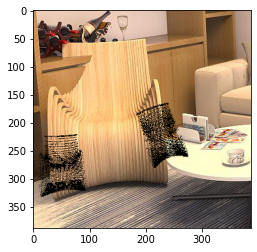

In [40]:
img_vis = project_to_image(verts_t1.numpy()[0], K.numpy()[0], img_vis)
plt.imshow(img_vis)

In [41]:
verts_t2 = project_to_camera(verts_t1, K)
print(verts_t2.min(), verts_t2.max())
print(verts_t2.size())

tensor(220.9375) tensor(456.0616)
torch.Size([1, 11930, 2])


In [38]:
def visualise_projection(points_img, img):
    ''' Visualises the vertex projection to the image plane.
        Args:
            points_img (numpy array): points projected to the image plane
            img (numpy array): image
            output_file (string): where the result should be saved
    '''
    plt.imshow(img.transpose(1, 2, 0))
    plt.plot(
            (points_img[:, 0] + 1) * img.shape[1]/2,
            (points_img[:, 1] + 1) * img.shape[2]/2, 'x')

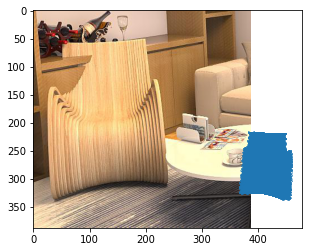

In [39]:
visualise_projection(verts_t2.numpy()[0], img.numpy()[0])